In [7]:
import scrapy
import json
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

% matplotlib inline
# https://stackoverflow.com/questions/42478231/how-to-scrape-infinite-scroll-page-of-kaggle-dataset-in-python

## scrape craigslist

In [208]:
entry=0
response = requests.get(f'https://sfbay.craigslist.org/search/sss?query=guitar&sort=rel')

soup=BeautifulSoup(response.content, 'html.parser')

In [164]:
#
items = soup.findAll("a", {"class": "result-image gallery"})

In [166]:
len(items)

118

In [163]:
soup.find(class="result-image gallery")

SyntaxError: invalid syntax (<ipython-input-163-169b6566bc88>, line 1)

In [153]:

total_results = data['totalDatasetListItems']
data=data['datasetListItems']

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

## scrape craigslist

We would like to scrape some data from craigslist.

Craigslist has a listing pages, with price and title, linked description pages, with more detailed data. 

From listing pages we can get 120 items per pages, so we are good. From the product pages, we can get one product per page, which puts us on a risk of getting banned.

I don't intend to use services to hide my IP or this kind of stuff, but I intend to save all my scraping every time I have this data at hand.

so lets start:

In [ ]:

response = requests.get(f'https://sfbay.craigslist.org/search/sss?query=guitar&sort=rel')

soup=BeautifulSoup(response.content, 'html.parser')

In [206]:
url_base = 'https://sfbay.craigslist.org/search/sss?&query=guitar&sort=rel'
params = dict(bedrooms=1, is_furnished=1)
rsp = requests.get(url_base, params=params)

In [23]:

response = requests.get(f'https://sfbay.craigslist.org/search/sss?query=guitar&sort=rel')

html=BeautifulSoup(response.content, 'html.parser')

# BS makes it easy to look through a document


In [24]:
html

This IP has been automatically blocked.
If you have questions, please email: blocks-b1519687729239462@craigslist.org

In [212]:
guitars = html.find_all('p', attrs={'class': 'result-info'})
len(guitars)

120

In [213]:
this = guitars[15]
print(this.prettify())

<p class="result-info">
 <span class="icon icon-star" role="button">
  <span class="screen-reader-text">
   favorite this post
  </span>
 </span>
 <time class="result-date" datetime="2018-02-25 22:12" title="Sun 25 Feb 10:12:43 PM">
  Feb 25
 </time>
 <a class="result-title hdrlnk" data-id="6482871679" href="https://sfbay.craigslist.org/sfc/msg/d/ovation-acoustic-electric/6482871679.html">
  Ovation Acoustic Electric Guitar, Elite Sunburst 6868, Made in  USA
 </a>
 <span class="result-meta">
  <span class="result-price">
   $305
  </span>
  <span class="result-hood">
   (mission district)
  </span>
  <span class="result-tags">
   pic
   <span class="maptag" data-pid="6482871679">
    map
   </span>
  </span>
  <span class="banish icon icon-trash" role="button">
   <span class="screen-reader-text">
    hide this posting
   </span>
  </span>
  <span aria-hidden="true" class="unbanish icon icon-trash red" role="button">
  </span>
  <a class="restore-link" href="#">
   <span class="restore

In [14]:
def find_prices(results):
    prices = []
    for rw in results:
        price = rw.find('span', {'class': 'result-price'})
        if price is not None:
            price = float(price.text.strip('$'))
        else:
            price = np.nan
        prices.append(price)
    return prices

def find_times(results):
    times = []
    for rw in apts:
        if time is not None:
            time = time['datetime']
            time = pd.to_datetime(time)
        else:
            time = np.nan
        times.append(time)
    return times

In [11]:
# craigslist is world wide, but before you search, you have to define a city to search in. We try to search in some populated cities in the us:
locs=['newyork','sfbay','losangeles']

In [8]:
final_results=pd.read_csv('guitar_scrape.csv')

In [20]:
url = f'https://sfbay.craigslist.org/search/sss?query=guitar&sort=rel'

In [22]:
requests.get(url)

<Response [403]>

In [15]:
results = []  # We'll store the data here
# Careful with this...too many queries == your IP gets banned temporarily

start =0
end = 6000 # from experimenting, there is not much results hgiher than 6000

search_indices = np.arange(start, end, 120)
results.append(final_results) # we will first get previous results

for loc in locs: #we'lll loop through our preset locations
    for i in search_indices:
        print(i)
        url = f'https://{loc}.craigslist.org/search/sss?query=guitar&sort=rel'

        resp = requests.get(url, params={ 's': i})
        txt = BeautifulSoup(resp.text, 'html.parser')
        guitars = txt.findAll(attrs={'class': "result-info"})

        # Find the title and link
        title = [rw.find('a', attrs={'class': 'hdrlnk'}).text for rw in guitars]
        links = [rw.find('a', attrs={'class': 'hdrlnk'})['href'] for rw in guitars]

        # Find the time
        time = [pd.to_datetime(rw.find('time')['datetime']) for rw in guitars]
        price = find_prices(guitars)

        # We'll create a dataframe to store all the data
        data = np.array([time, price, title, links,''*len(time)])
        col_names = ['time', 'price', 'title', 'link','description']
        df = pd.DataFrame(data.T, columns=col_names)
        df = df.set_index('time')

        # Add the location variable to all entries

        results.append(df)




0


ValueError: Shape of passed values is (1, 5), indices imply (5, 5)

In [599]:
# Finally, concatenate all the results. We should further clean them, and remove results with no price
final_results = pd.concat(results, axis=0)
final_results=final_results.drop_duplicates('link')
len(final_results)

7812

In [606]:
# scrape descriptions. update only those which are empty

descriptions=[]
for i,result in enumerate(final_results.iterrows()):
    if result[1].price>0 and result[1].description=='':
        url = result[1].link
        resp = requests.get(url)
        txt = bs4(resp.text, 'html.parser')
        description=txt.findAll(attrs={'id': "postingbody"})
        try:
            descriptions.append(description[0].text)
        except:
            descriptions.append('')
    else:
        descriptions.append(result[1].description)
    print(i) if i % 100 ==0 else ''

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
1620
1640
1660
1680
1700
1720
1740
1760
1780
1800
1820
1840
1860
1880
1900
1920
1940
1960
1980
2000
2020
2040
2060
2080
2100
2120
2140
2160
2180
2200
2220
2240
2260
2280
2300
2320
2340
2360
2380
2400
2420
2440
2460
2480
2500
2520
2540
2560
2580
2600
2620
2640
2660
2680
2700
2720
2740
2760
2780
2800
2820
2840
2860
2880
2900
2920
2940
2960
2980
3000
3020
3040
3060
3080
3100
3120
3140
3160
3180
3200
3220
3240
3260
3280
3300
3320
3340
3360
3380
3400
3420
3440
3460
3480
3500
3520
3540
3560
3580
3600
3620
3640


KeyboardInterrupt: 

In [607]:
descriptions=descriptions+['']*(len(final_results)-len(descriptions))
final_results['description']=descriptions
# clearn description a little bit more
final_results['description'] = final_results.apply(lambda row: row['description'].replace("\n\nQR Code Link to This Post\n\n\n", ""), axis=1)

In [608]:
len(final_results)

7812

In [609]:
final_results.to_csv('guitar_scarpe.csv')

In [ ]:
final_results.to_csv('guitar_scrape.csv')

In [ ]:
# further tasks
# 1. clean description V
# 2. parse description

In [ ]:
# bag of words with
    # tf idf
    # naive bayes
# xgboost

In [631]:
# remove entires with no price
final_results_price=final_results[~final_results.price.isna()]

In [664]:
final_results_price=final_results_price[final_results_price.description!='']

In [665]:
len(final_results_price)

2068

In [633]:
final_results_price.head()

,price,title,link,description
time,,,,
2018-02-26 01:18:00,175,chinese type lute guitar,https://sfbay.craigslist.org/pen/msg/d/chinese...,my wife is selling her chinese style lute guit...
2018-02-26 00:54:00,200,Fernandes FR-50 Guitar,https://sfbay.craigslist.org/eby/msg/d/fernand...,Fernandes FR-50 Guitar in excellent condition
2018-02-26 00:54:00,150,EMMA Electronic PY-1 PisdiYAUwot Guitar Distor...,https://sfbay.craigslist.org/eby/msg/d/emma-el...,EMMA Electronic PY-1 PisdiYAUwot Guitar Distor...
2018-02-25 23:44:00,2700,New / Ibanez Guitar J-Custom RG8420ZD RS 2016,https://sfbay.craigslist.org/eby/msg/d/new-iba...,Brand new / Never used\n\nMade in Japan (By Te...
2018-02-25 22:12:00,1075,Gibson Guitar 1959 ES-125TC,https://sfbay.craigslist.org/sfc/msg/d/gibson-...,Here's a mojo filled Gibson ES-125TC from 1959...


### Look at the data

In [629]:
final_results_price.description[7]

'Selling my Gibson / Epiphone Acoustic Guitar AJ 18S for $250 OBO.\n\nGreat acoustic guitar but selling this as I recently got married and my wife (who also has a guitar) do not need 2 guitars for the both of us.\n\nIncludes hard shell case.    '

In [630]:
final_results_price.title[5]

'Ovation Acoustic Electric Guitar, Elite Sunburst 6868, Made in  USA'

OK, so we have <1393> rows. I can see some more dirt right here: price of 1$ etc. but lets go on.

First, lets encode the data.

Thats it, we have 2068 guitars, out of X we were able to scrape before craigslist stopped us

## Data preperation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer

In [622]:
lens = final_results_price.description.str.len()
lens.mean(), lens.std(), lens.max()

(719.2625725338492, 1083.897413731805, 20967)

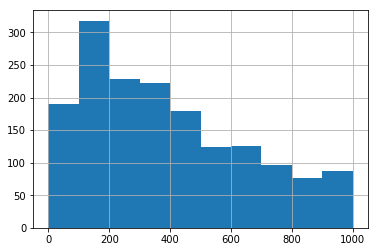

In [623]:
lens.hist(range=(0, 1000));

In [636]:
lens = final_results_price.title.str.len()
lens.mean(), lens.std(), lens.median()

(42.34293640631669, 15.72566237180576, 41.0)

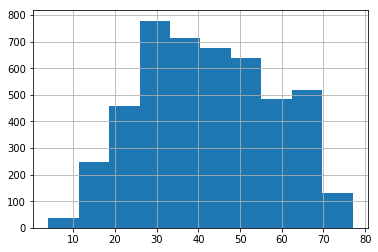

In [635]:
lens.hist()

In [454]:
# so we need a good tokenizer... this is not a good one, but... well... use spacy for the next time
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [666]:
nlp = spacy.load('en')  # <-- an instance of `English` with data loaded in
doc = nlp(u"This is a text.")

In [670]:
# split
train,test=train_test_split(final_results_price)

In [671]:
n = final_results_price.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize, min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,smooth_idf=1, sublinear_tf=1 )

train_term_doc = vec.fit_transform(train['description'])
test_term_doc = vec.transform(test['description'])

In [672]:
train_term_doc

<1551x18264 sparse matrix of type '<class 'numpy.float64'>'
	with 247002 stored elements in Compressed Sparse Row format>

In [525]:
# count vectorizer
n = final_results_price.shape[0]
count = CountVectorizer(ngram_range=(1,2), tokenizer=tokenize, min_df=3, max_df=0.9, strip_accents='unicode')

train_term_doc_count = count.fit_transform(train['description'])
test_term_doc_count = count.transform(test['description'])

In [526]:
train_term_doc_count

<1044x12740 sparse matrix of type '<class 'numpy.int64'>'
	with 164633 stored elements in Compressed Sparse Row format>

## models and predictions

In [ ]:
import xgboost as xgb
from collections import Counter

In [673]:
reg = linear_model.LinearRegression()
reg.fit(train_term_doc,train.price)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [674]:
sum(final_results_price.price>2000)

190

In [675]:
np.std(test.price.values),np.mean(test.price.values),np.median(test.price.values)

(1625.0754591184775, 739.7021276595744, 250.0)

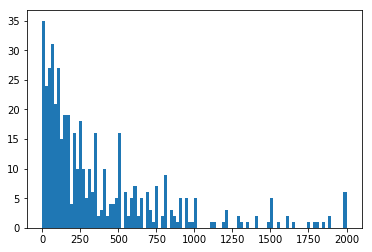

In [676]:
fig, ax = plt.subplots()

ax.hist(list(test.price.values),bins=100,range=(0, 2000))

plt.show()

In [677]:
preds=reg.predict(test_term_doc)

In [678]:
# fix some stupid bugs in the regression
preds[preds>2000]=2000
preds[preds<0]=0

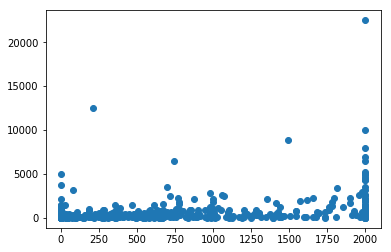

In [679]:

plt.scatter(preds,test.price.values)

In [681]:
np.sqrt(mean_squared_error(preds,test.price.values))

1526.4878540088598

In [682]:
# ridge regression
reg = linear_model.Ridge (alpha = .5)
reg.fit(train_term_doc,train.price)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [683]:
preds=reg.predict(test_term_doc)

In [694]:
# fix some stupid bugs in the regression
preds[preds>2000]=2000
preds[preds<0]=0

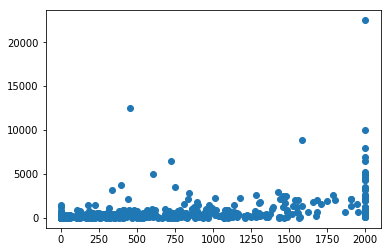

In [695]:
plt.scatter(preds,test.price.values)

In [696]:
np.sqrt(mean_squared_error(preds,test.price.values))

1465.210210473001

80 bucks?  better than 93bucks, but still nor great

lets xgboost-a

In [686]:
dtrain = xgb.DMatrix(train_term_doc, train.price)
dvalid = xgb.DMatrix(test_term_doc, test.price)

In [687]:
regressor = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [688]:
regressor.fit(train_term_doc, train.price)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.08, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)

In [689]:
predictions = regressor.predict(test_term_doc)

In [699]:
# fix some stupid bugs in the regression
predictions[predictions>2000]=2000
predictions[predictions<0]=0

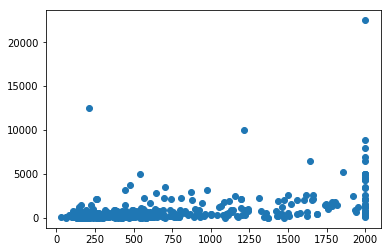

In [700]:
plt.scatter(predictions,test.price.values)

In [701]:
np.sqrt(mean_squared_error(predictions,test.price.values))
# here and above the fix doesnt do so good.

1443.3100136383373

In [ ]:

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
# need to set params:
params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 

gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=5)
xgb.plot_importance(final_gb)


## Word2vec

OK, enough with the games. lets pull out our secret weapons - the word2vec, and hope the vectors for fender and Gibson are close (perhaps Fender-Money=Gibson. OR Fender+Slash=Gibson. or whatever/

this is the strange Jeremy way to load word vectors. Change to the original gLoVe way

In [2]:
import bcolz
import pickle

In [3]:
def load_array(file_name):
    return bcolz.open(file_name)[:]

In [4]:
def load_vectors(loc):
    return (load_array(loc + '.dat'),pickle.load(open(loc + '_words.pkl', 'rb'), encoding='latin1'), pickle.load(open(loc + '_idx.pkl', 'rb'), encoding='latin1'))

In [6]:
vectors, words, word_idx = load_vectors('/media/gidi/cf8dba8d-79f9-4bca-9076-1ddb14211382/text_models/glove/6B.300d')